# Predicting monthly average CO2 levels at Mauna Loa

imports

In [21]:
from pathlib import Path

import pandas as pd
import numpy as np
from numpy.linalg import slogdet
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt

define where the raw data is stored

In [3]:
RAW_DATA_PATH = Path("./data/raw.csv").resolve()

## Load & clean the data

open the file and get the columns we need

In [9]:
with open(RAW_DATA_PATH, 'r') as raw_file:
    df = pd.read_csv(
        raw_file, 
        header=51, 
        usecols=["decimal date", "average", "interpolated"],
        index_col=False, 
    ).rename(columns={
        "decimal date": "year",
    })

make a simple plot to look at the data

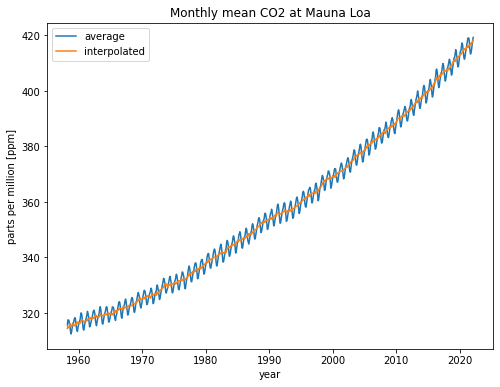

In [10]:
    ax = df.plot(
        title="Monthly mean CO2 at Mauna Loa",
        x="year", 
        y=["average", "interpolated"], 
        ylabel="parts per million [ppm]",
        figsize=(8,6)
    )

## Split into test & train data

In [11]:
SPLIT_YEAR = 2000

In [12]:
before_idx = df["year"] < SPLIT_YEAR
after_idx = df["year"] >= SPLIT_YEAR

train_df = df.loc[before_idx]
test_df = df.loc[after_idx]

## Training

set hyperparameters

In [14]:
SCALE = 0.01
LOC = 1958.2027
NOISE_PRECISION = 10
PRIOR_PRECISION = 0.1
SEASON_SHIFT = -0.08
CYCLE_LEN = -29
CYCLE_SHIFT = 8

In [15]:
def build_features(year):
    """Compute feature vector for a given year."""
    rescaled = SCALE * (year - LOC)
    return np.array([
        [1.] * len(rescaled),
        rescaled**5,
        np.sin(2 * np.pi * (year + SEASON_SHIFT)),
        np.sin(2 * np.pi * (year + CYCLE_SHIFT) / CYCLE_LEN),
        np.exp(rescaled),
    ])

actual Gaussian parametric regression below

In [17]:
year = train_df["year"].values
target = train_df["average"].values

features = build_features(year)
num_features = features.shape[0]

# prior on the weights
prior_mean = np.zeros(num_features)
prior_covmat = np.eye(num_features) / PRIOR_PRECISION

# implied prior on function
mean_fn = features.T @ prior_mean
kernel_fn = features.T @ prior_covmat @ features

# the 'error' of the data
llh_covmat = np.eye(features.shape[1]) / NOISE_PRECISION

# invert a part efficiently and stably
cho_decomp = cho_factor(kernel_fn + llh_covmat * (1e-6 + 1.))
sol = cho_solve(cho_decomp, (prior_covmat @ features).T).T

# posterior mean and covariance
post_mean = prior_mean + sol @ (target - features.T @ prior_mean)
post_covmat = prior_covmat - sol @ features.T @ prior_covmat

## Evaluate fit

In [20]:
year = test_df["year"].values
targets = test_df["average"].values

# features for test data
features = build_features(year)
num_features = features.shape[0]

# compute posterior predictive
post_predict_mean = features.T @ post_mean
post_predict_covmat = (
    features.T @ post_covmat @ features 
    + np.eye(len(targets)) * NOISE_PRECISION
)

# compute log-evidence of data given posterior predictive
diff = targets - post_predict_mean
cho_decomp = cho_factor(post_predict_covmat)
sol = cho_solve(cho_decomp, diff)
_, occam_factor = slogdet(post_predict_covmat)
log_evi = - 0.5 * diff @ sol - 0.5 * occam_factor
rmse = np.sqrt(np.mean(diff @ diff))

print(f"log-evidence = {log_evi:.2f}")
print(f"RMSE = {rmse:.2f}")

log-evidence = -370.91
RMSE = 42.71


## Plots

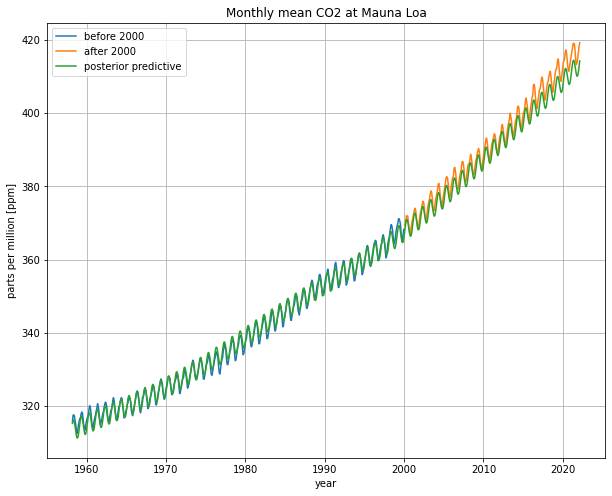

In [25]:
train_df = train_df.rename({
    "average": "before 2000"
}, axis="columns")
test_df = test_df.rename({
    "average": "after 2000"
}, axis="columns")

year = np.array([*train_df["year"].values, *test_df["year"].values])

features = build_features(year)
num_features = features.shape[0]

# compute posterior predictive
post_predict_mean = features.T @ post_mean

fig, ax = plt.subplots(figsize=(10,8))
train_df.plot(
    title="Monthly mean CO2 at Mauna Loa",
    x="year",
    y="before 2000",
    xlabel="Year",
    ylabel="parts per million [ppm]",
    ax=ax,
);
test_df.plot(
    x="year",
    y="after 2000",
    ax=ax
);
ax.plot(year, post_predict_mean, label="posterior predictive");
ax.grid("on");
ax.legend();